In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
pip install listoflist

In [ ]:
import listoflist

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

In [ ]:
df=pd.read_csv('/content/Data Analyst - Test Data - US.csv')

In [ ]:
df.head()

,Review,date,Location
0,I was very impressed with the resort.\n Great ...,2019/08/20,Sebastian
1,The rooms were nice the outside needs work als...,2019/08/20,Los Angeles
2,Great location! I have stayed at this hotel on...,2019/08/20,Georgia
3,The hotel was adequate for my stay. The strips...,2019/08/20,NaN
4,"Great location, room was large and spacious. P...",2019/08/19,Palm Harbor


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review    6393 non-null   object
 1   date      6448 non-null   object
 2   Location  1711 non-null   object
dtypes: object(3)
memory usage: 151.2+ KB


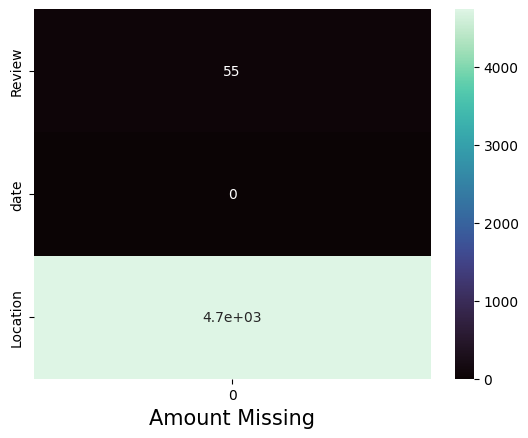

In [ ]:
sns.heatmap(df.isna().sum().to_frame(),annot=True,cmap='mako')
plt.xlabel('Amount Missing',fontsize=15)
plt.show()

In [ ]:
df.isnull().sum()

Review        55
date           0
Location    4737
dtype: int64

In [ ]:
df = df.iloc[:,0:1]

In [ ]:
df.head()

,Review
0,I was very impressed with the resort.\n Great ...
1,The rooms were nice the outside needs work als...
2,Great location! I have stayed at this hotel on...
3,The hotel was adequate for my stay. The strips...
4,"Great location, room was large and spacious. P..."


In [ ]:
df = df.dropna()

In [ ]:
df.isna().sum()

Review    0
dtype: int64

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
df['Review'] = df['Review'].str.replace("\n","")
df['Review'] = df['Review'].str.replace("Read more","")
df['Review'] = df['Review'].str.replace("Read less","")
import re
df['Review'] = df['Review'].apply(lambda x: re.sub(r'[^\w\s]', '', x))


In [ ]:
df.Review.head()

0    I was very impressed with the resort Great sta...
1    The rooms were nice the outside needs work als...
2    Great location I have stayed at this hotel on ...
3    The hotel was adequate for my stay The strips ...
4    Great location room was large and spacious Par...
Name: Review, dtype: object

In [ ]:
def senti(review):
    if sid.polarity_scores(review)['compound'] >= 0:
        return 'pos'
    else:
        return 'neg'
df['sentiment'] = df['Review'].apply(lambda x: senti(x))

In [ ]:
df.describe()

,Review,sentiment,aspect,description
count,6393,6393,6393,6393
unique,6378,2,999,1507
top,Amazing,pos,,
freq,5,5049,1989,474


In [ ]:
df.head()

,Review,sentiment
0,I was very impressed with the resort Great sta...,pos
1,The rooms were nice the outside needs work als...,pos
2,Great location I have stayed at this hotel on ...,pos
3,The hotel was adequate for my stay The strips ...,pos
4,Great location room was large and spacious Par...,pos


<Axes: xlabel='sentiment', ylabel='count'>

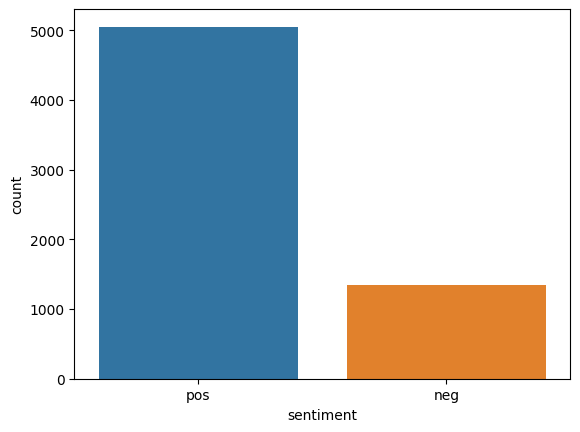

In [ ]:
sns.countplot(x='sentiment',data=df)

In [ ]:
def pos_tagging(data):
    req_tag = ['NN']
    extracted_words = []
    i = 0
    try:
        for x in data['Review']:
            doc = nlp(x)
            for token in doc:
                i += 1
                if token.tag_ in req_tag and token.shape_ != 'x' and token.shape_ != 'xx' and token.shape_ != 'xxx':
                    extracted_words.append(token.lemma_)
        return extracted_words
    except Exception as e:
        return extracted_words
extracted_words = pos_tagging(df)
ser = pd.Series(extracted_words).value_counts().head(10)
index = ser.index
value = ser.values
index

Index(['room', 'hotel', 'staff', 'location', 'service', 'time', 'night',
       'stay', 'parking', 'desk'],
      dtype='object')

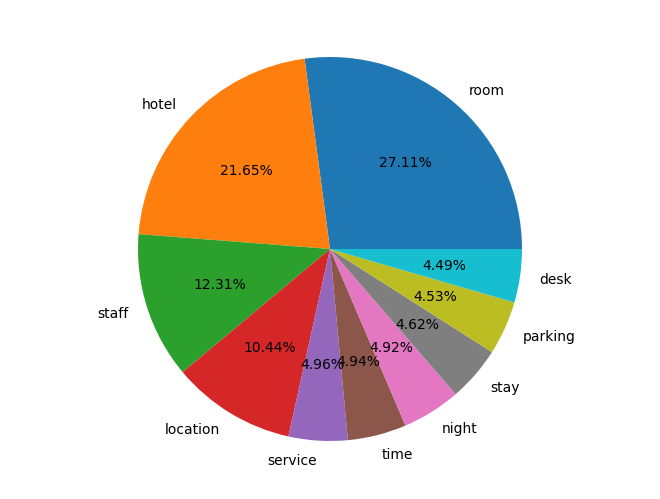

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
freq = index
val = value
ax.pie(val, labels = freq,autopct='%1.2f%%')
plt.show()

In [ ]:
aspect = []
description = []

for sentence in df['Review']:
    doc = nlp(sentence)
    descriptive_term = ''
    target = ''
    for token in doc:
        if token.dep_ == 'nsubj' and token.pos_ == 'NOUN':
            target = token.text
        if token.pos_ == 'ADJ':
            prepend = ''
            for child in token.children:
                if child.pos_ != 'ADV':
                    continue
                prepend += child.text + ' '
            descriptive_term = prepend + token.text
    aspect.append(target)
    description.append(descriptive_term)
df['aspect'] = aspect
df['description'] = description

In [ ]:
df.head()

,Review,sentiment,aspect,description
0,I was very impressed with the resort Great sta...,pos,,very reasonable
1,The rooms were nice the outside needs work als...,pos,rooms,nice
2,Great location I have stayed at this hotel on ...,pos,,last
3,The hotel was adequate for my stay The strips ...,pos,strips,andor
4,Great location room was large and spacious Par...,pos,Parking,friendly


In [ ]:
df['aspect'] = df['aspect'].str.replace('beds','bed')
df['aspect'] = df['aspect'].str.replace('rooms','room')
df['aspect'].value_counts().head(10)

            1989
room         517
staff        318
hotel        293
location     182
bed          107
service       66
place         63
property      58
area          54
Name: aspect, dtype: int64

<Axes: xlabel='aspect', ylabel='count'>

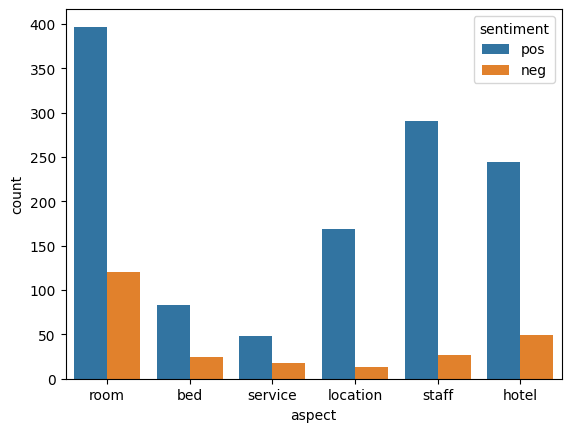

In [ ]:
new = df[(df['aspect'] == 'room') | (df['aspect'] == 'staff') | (df['aspect'] == 'hotel') |(df['aspect'] == 'location') | (df['aspect'] == 'bed') |(df['aspect'] == 'service')][['sentiment','aspect']]
sns.countplot(x='aspect',data=new, hue='sentiment')

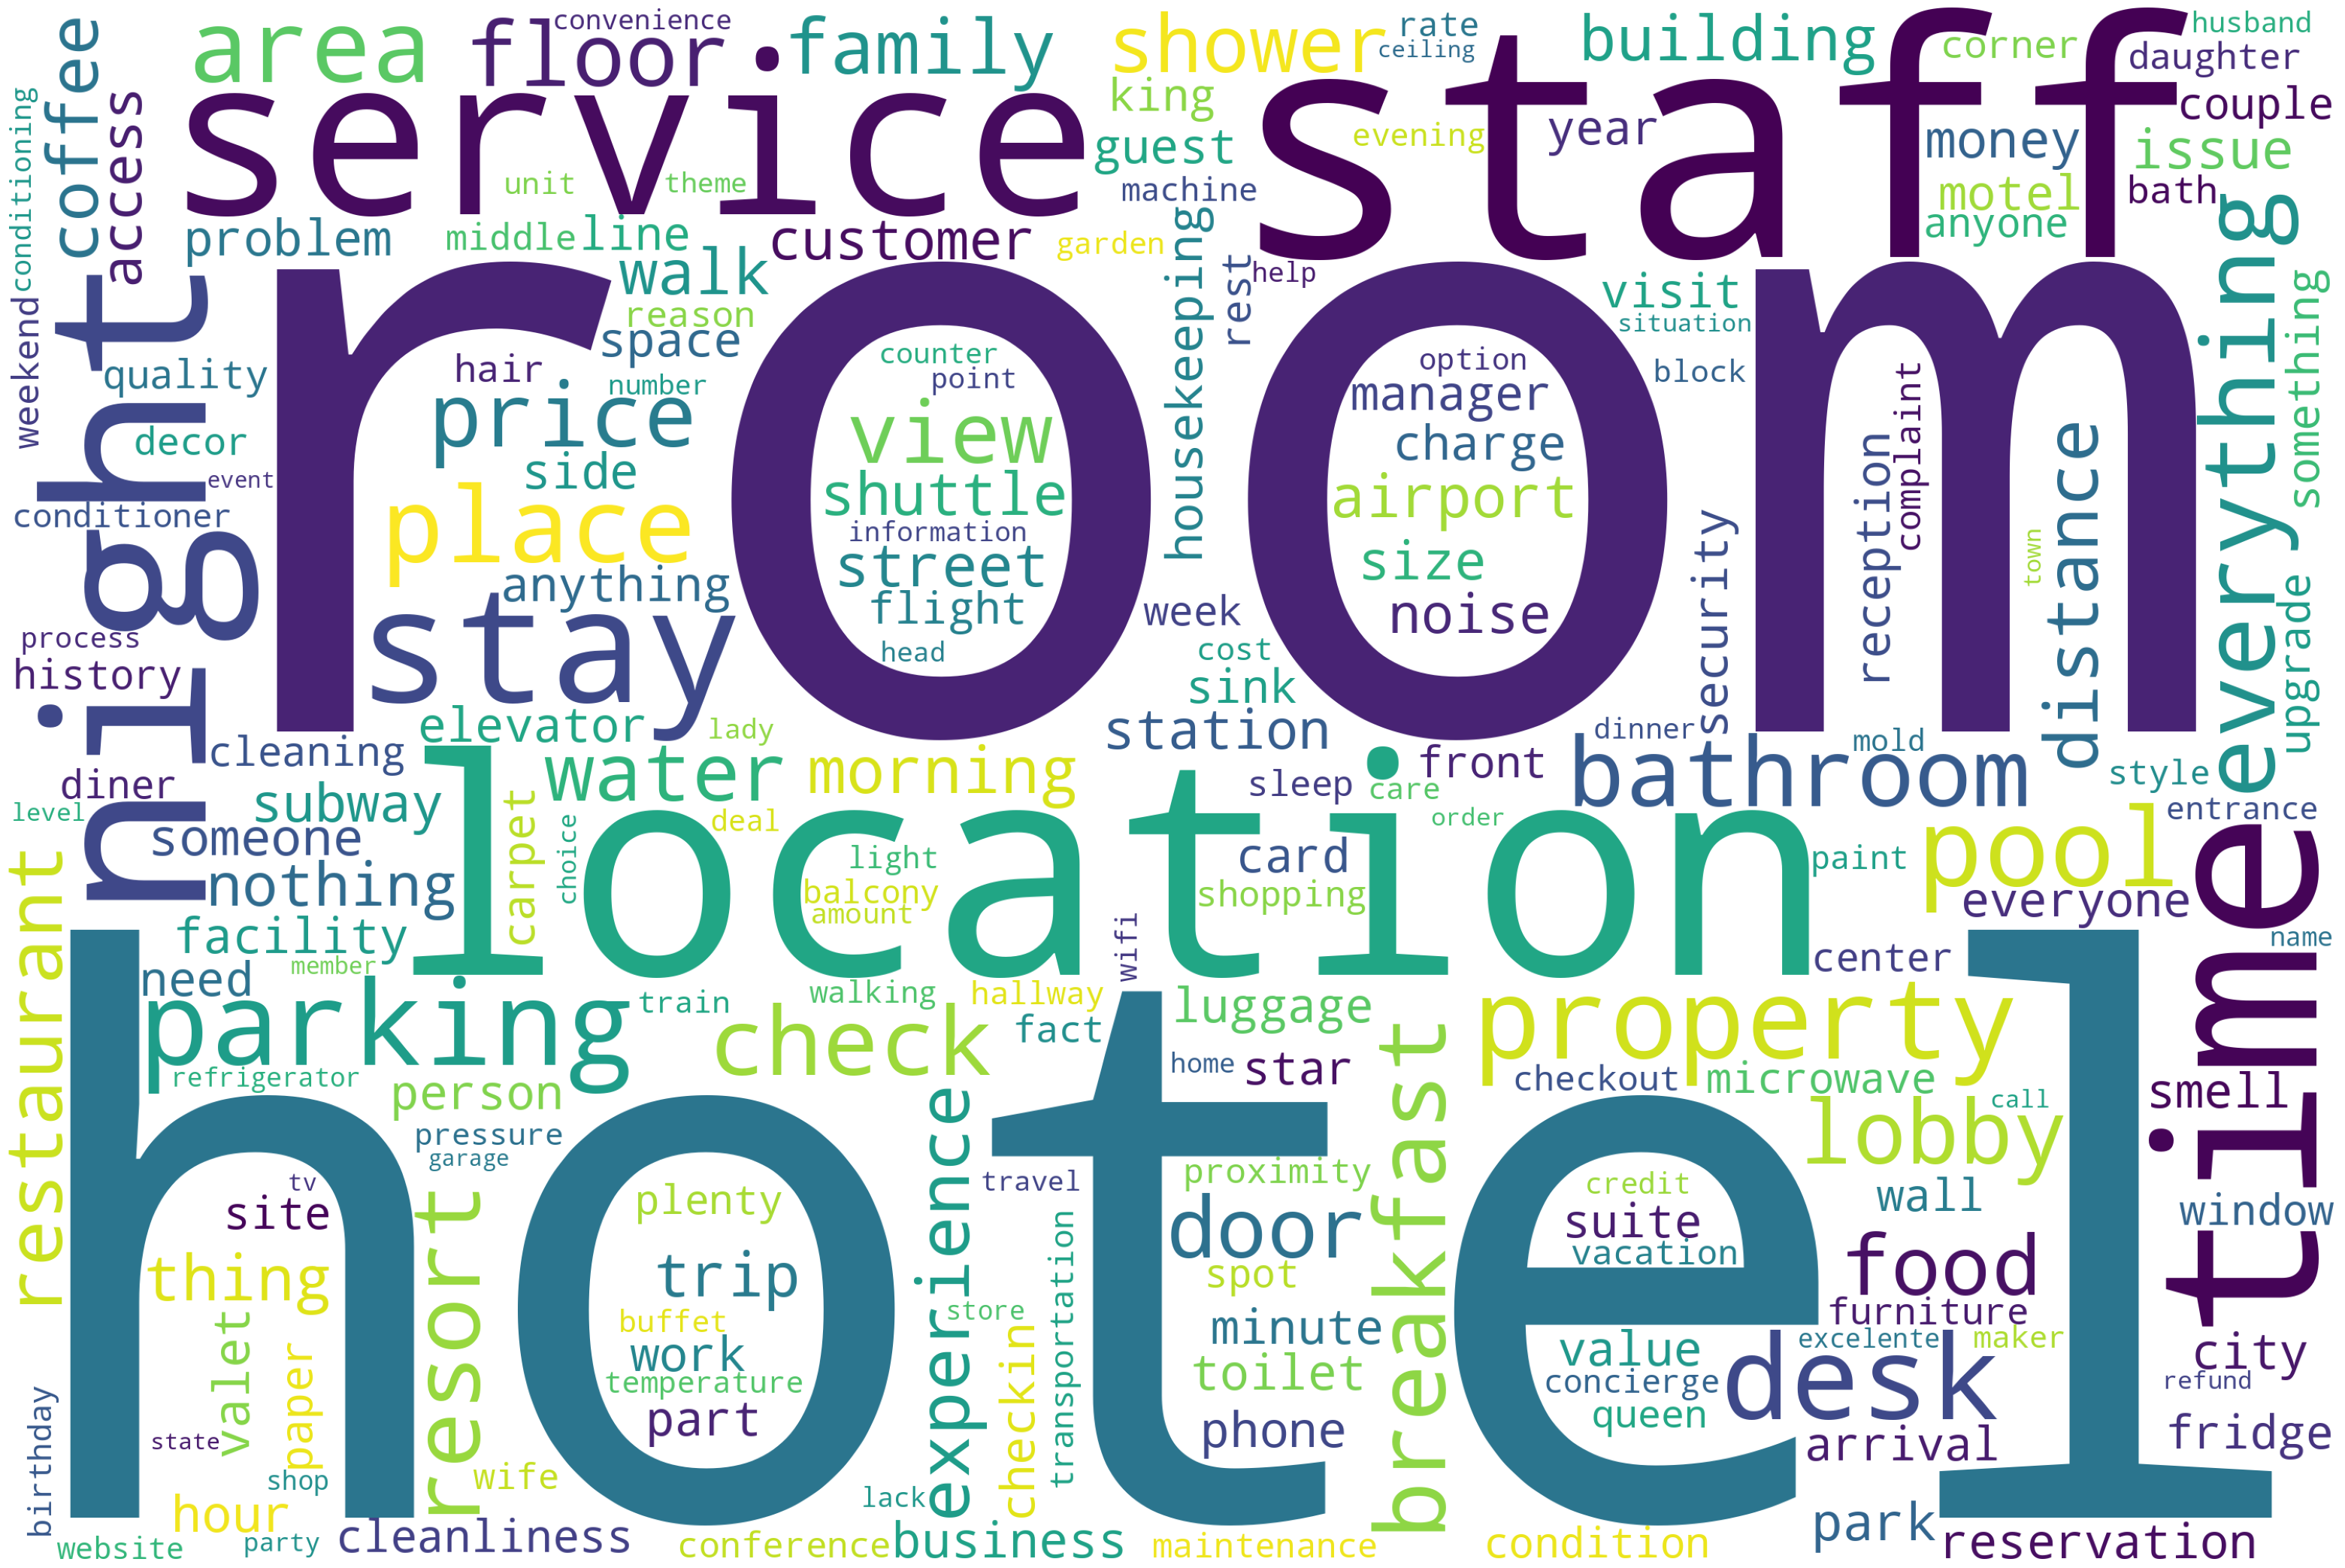

In [ ]:
from wordcloud import WordCloud, STOPWORDS
def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud)
    plt.axis("off")
unique_string=(" ").join(extracted_words)
wordcloud = WordCloud(width = 3000, height = 2000,background_color='white',random_state=1, collocations=False, stopwords = STOPWORDS).generate(unique_string)

plot_cloud(wordcloud)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
import csv
X=df['Review']
Y=df['sentiment']


In [ ]:
vectorizer= TfidfVectorizer()
vectorizer.fit(X)
X= vectorizer.transform(X)
print(X)

  (0, 13442)	0.2519883591489871
  (0, 13273)	0.11493681671411361
  (0, 13229)	0.07707104429402097
  (0, 12970)	0.2078827212322787
  (0, 12036)	0.213383429397325
  (0, 12028)	0.13410088058336336
  (0, 11396)	0.22057215959854565
  (0, 10108)	0.36134043862877585
  (0, 9786)	0.2757438622934692
  (0, 9468)	0.25457598720489744
  (0, 9220)	0.1707054898153159
  (0, 7436)	0.25783841857789747
  (0, 7261)	0.12099291825966704
  (0, 6302)	0.30518243289171754
  (0, 5704)	0.126882468348022
  (0, 5553)	0.237771226356272
  (0, 2552)	0.1218632467978131
  (0, 1839)	0.3645455967322459
  (0, 1519)	0.21775000884919463
  (0, 1287)	0.12099291825966704
  (0, 1025)	0.06876523653180316
  (1, 13505)	0.1966414849056971
  (1, 13481)	0.26573754628533997
  (1, 13339)	0.15236497677775437
  (1, 13229)	0.09880354087668487
  :	:
  (6391, 6314)	0.2991393963295303
  (6391, 6116)	0.2559128839678484
  (6391, 5050)	0.11014678242638454
  (6391, 4066)	0.24859975602251197
  (6391, 2440)	0.5380661658861973
  (6391, 1647)	0.236862

In [ ]:
def senti(review):
    if sid.polarity_scores(review)['compound'] >= 0:
        return 1
    else:
        return 0
df['sentiment'] = df['Review'].apply(lambda x: senti(x))

In [ ]:
df.head()

,Review,sentiment,aspect,description
0,I was very impressed with the resort Great sta...,1,,very reasonable
1,The rooms were nice the outside needs work als...,1,room,nice
2,Great location I have stayed at this hotel on ...,1,,last
3,The hotel was adequate for my stay The strips ...,1,strips,andor
4,Great location room was large and spacious Par...,1,Parking,friendly


In [ ]:
X=df['Review']
Y=df['sentiment']
X.shape

(6393,)

In [ ]:
scaler=StandardScaler()

In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=3)
X_train.shape

(5114,)

In [ ]:
print(X.shape,X_test.shape,X_train.shape)

(6393,) (1279,) (5114,)


In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [ ]:
model= LogisticRegression()

In [ ]:
X=df['Review'].values
print(X)

['I was very impressed with the resort Great staff at the main resort pool bar We had a blast with them Clean professional staff great location and very reasonable      '
 'The rooms were nice the outside needs work also no free breakfast it would have been nice overall it was ok      '
 'Great location I have stayed at this hotel on my last three trips to New York      '
 ...
 'the location was great     the bed was the most uncomfortable bed i have ever been in'
 'we were early for check in and the staff was very accommodating we were able to check in several hours before the check in time'
 'staff free coffee location and activities     the beds were smaller than we thought and not very comfortable']


In [ ]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
import csv


In [ ]:
vectorizer= TfidfVectorizer()
vectorizer.fit(X)
X= vectorizer.transform(X)
print(X)

  (0, 13442)	0.2519883591489871
  (0, 13273)	0.11493681671411361
  (0, 13229)	0.07707104429402097
  (0, 12970)	0.2078827212322787
  (0, 12036)	0.213383429397325
  (0, 12028)	0.13410088058336336
  (0, 11396)	0.22057215959854565
  (0, 10108)	0.36134043862877585
  (0, 9786)	0.2757438622934692
  (0, 9468)	0.25457598720489744
  (0, 9220)	0.1707054898153159
  (0, 7436)	0.25783841857789747
  (0, 7261)	0.12099291825966704
  (0, 6302)	0.30518243289171754
  (0, 5704)	0.126882468348022
  (0, 5553)	0.237771226356272
  (0, 2552)	0.1218632467978131
  (0, 1839)	0.3645455967322459
  (0, 1519)	0.21775000884919463
  (0, 1287)	0.12099291825966704
  (0, 1025)	0.06876523653180316
  (1, 13505)	0.1966414849056971
  (1, 13481)	0.26573754628533997
  (1, 13339)	0.15236497677775437
  (1, 13229)	0.09880354087668487
  :	:
  (6391, 6314)	0.2991393963295303
  (6391, 6116)	0.2559128839678484
  (6391, 5050)	0.11014678242638454
  (6391, 4066)	0.24859975602251197
  (6391, 2440)	0.5380661658861973
  (6391, 1647)	0.236862

In [ ]:
model= LogisticRegression()

In [ ]:
model.fit(X,Y)

LogisticRegression()

In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=3)
X_train.shape

(5114, 14120)

In [ ]:
model.fit(X_train,Y_train)

LogisticRegression()

In [ ]:
# accuracy on data
X_test_prediction=model.predict(X_test)
test_data_accuracy= accuracy_score(X_test_prediction, Y_test)

In [ ]:
print('Accuracy on test data:',test_data_accuracy)

Accuracy on test data: 0.8483189992181391


In [ ]:
X_train_prediction=model.predict(X_train)
test_data_accuracy= accuracy_score(X_train_prediction, Y_train)
print('Accuracy on training data:',test_data_accuracy)

Accuracy on training data: 0.8979272585060618


In [ ]:
pip install reverse_geocoder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for reverse_geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268064 sha256=fb528a80683dc46355fbb2c83ffd5f35e548a291980142f467f0ebedffa29da4
  Stored in directory: /root/.cache/pip/wheels/bd/e5/88/eb139b6d6a26b8022d370ab991f7a836802fed9871975ec6d9
Successfully built reverse_geocoder


In [ ]:
pip install django-countries

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 843.2/843.2 kB 9.0 MB/s eta 0:00:00
